In [21]:
# Getting the image

# Loading and Vectorising it

# Choosing and separating the patches

# Performing matrix factorization

# Recombining the compressed patch with all the values.

In [22]:
# Importing Libraries

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

from einops import rearrange
from sklearn import preprocessing

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

torch.Size([3, 1365, 2048])


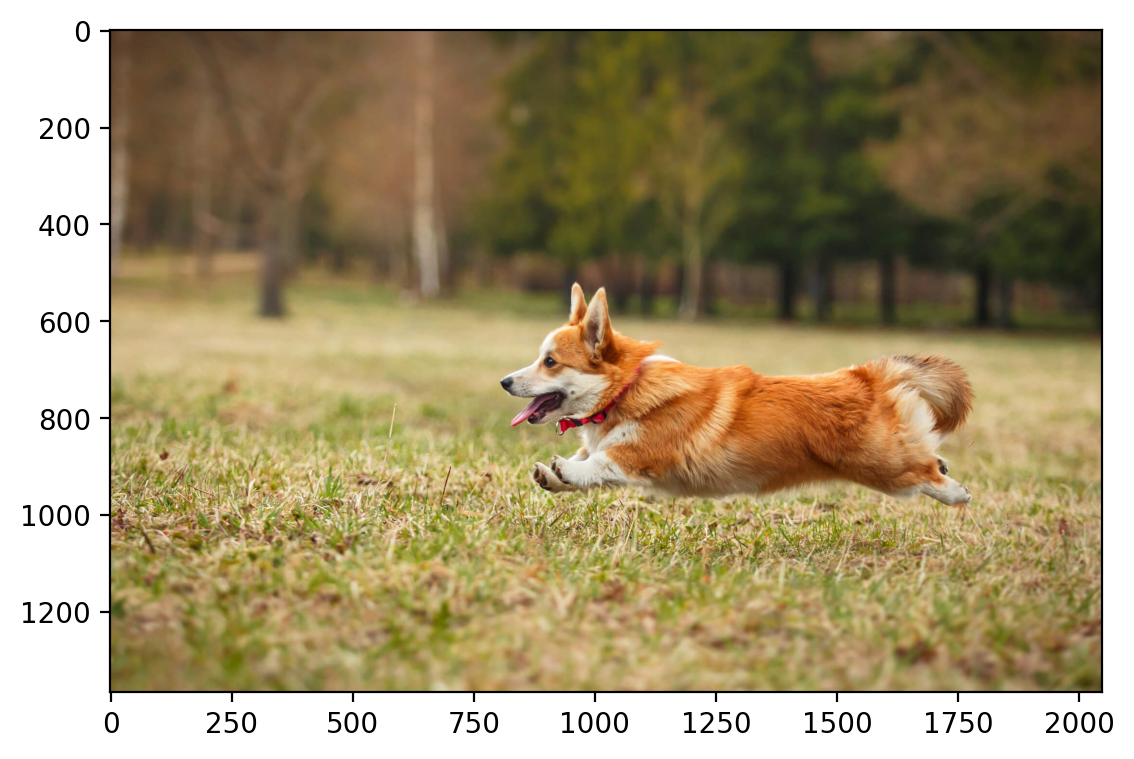

In [23]:
# Reading and showing the image


# Read in a image from torchvision
# This function reads the image and loads it as a tensor. It will have a shape (Color channels, Height, Width)
img = torchvision.io.read_image("..\sample_images\dog.jpg")
print(img.shape)

# Rearranges the axes
# PyTorch typically represents images as tensors with the shape (C, H, W)
# Matplotlib expects images to be in the shape (H, W, C)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [24]:
# Transformation

# preprocessing.MinMaxScaler() is a scaler from the sklearn library that scales data to a specified range, usually between 0 and 1.
# img.reshape(-1, 1) reshapes the image tensor into a 2D array with one column and 3 rows
# -1 means the number of rows is inferred based on the original array size
print(img.shape)

# So basically the 3d array is reduced to a single column to normalise it.
print(img.reshape(-1,1).shape)
# This scler_img stores the transformation
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))

# Now the transformation is performed using the factors and it is reshaped.
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
print(img_scaled.shape)

img_scaled = img_scaled.to(device)
img_scaled

torch.Size([3, 1365, 2048])
torch.Size([8386560, 1])
torch.Size([3, 1365, 2048])


tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

torch.Size([3, 300, 300])


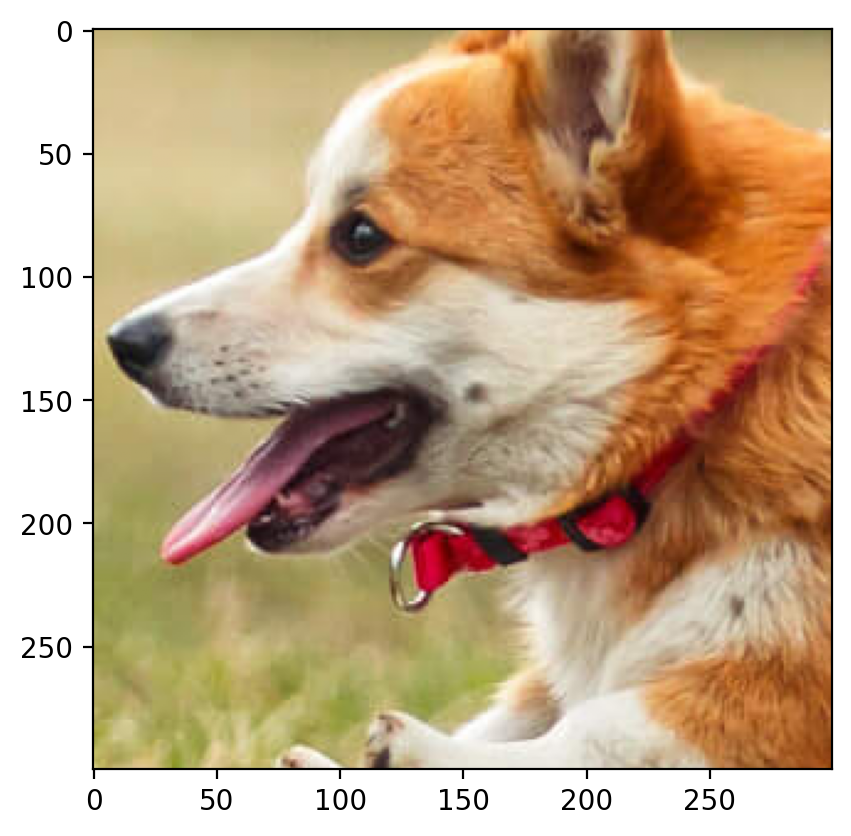

In [25]:
# Cropping the image

# the arguments are  (image, starting[depth], starting[length], length, breadth)
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())



In [26]:
# Extract the patch

def extract_patch(new_crop, start_h, start_w, patch_size=50):
    patch = new_crop[:, start_h:start_h + patch_size, start_w:start_w + patch_size]
    # print("Patch shape:", patch.shape) 
    
    return patch


In [27]:
def grad_descent(A, r, device=torch.device("cpu"), tolerance=1e-6, max_iters=1000, alpha=0.01):
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)

    for i in range(max_iters*10):
        reconstructed = torch.mm(W, H)
        
        # Compute the loss
        loss = torch.norm(reconstructed - A)
        
        # Zero the gradients
        W.grad = None
        H.grad = None
        
        # Compute gradients manually
        loss.backward()
        
        # Update W and H
        with torch.no_grad():
            W -= alpha * W.grad
            H -= alpha * H.grad

        # Check for convergence
        if loss.item() < tolerance:
            print(f"Converged at epoch {i} with loss: {loss.item()}")
            break

    return W, H, loss

In [28]:
# Apply factorize on all the three channels one by one 

def factorize(A, r, device=torch.device("cpu"), tolerance=1e-6, max_iters=1000, alpha=0.01):
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)
    
    # Optimizer
    optimizer = optim.Adam([W, H], lr=alpha)
    
    # Train the model
    for i in range(max_iters):
        # Compute the loss
        loss = torch.norm(torch.mm(W, H) - A)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()

        if loss.item() < tolerance:
            # print(f"Converged at iteration {i} with loss: {loss.item()}")
            break
        
    return W, H, loss

def factorization_to_channels(tensor, r, device=torch.device("cpu"), iters=1000, alpha=0.01): 
    new_tensor = torch.zeros_like(tensor).to(device)
    # sigmoid = nn.Sigmoid()

    for channel in range(tensor.shape[0]):
        A = tensor[channel]  # Get the 2D matrix for the current channel
        W, H, loss = factorize(A, r, device=device, max_iters=iters, alpha=alpha)  # Factorize the 2D matrix
        new_tensor[channel] = torch.mm(W, H)
        # print(f"Loss of channel {channel}: ", loss.item())

    # min_val = new_tensor.min()
    # max_val = new_tensor.max()
    # new_tensor = (new_tensor - min_val) / (max_val - min_val)
    return new_tensor
    



In [29]:
# Visualising the patches

def plot_patches(patch, compress_patch):
    # Create a figure
    plt.figure(figsize=(5, 3))

    # Plot the extracted patch
    plt.subplot(1, 2, 1)
    # print(patch)
    plt.imshow(rearrange(patch, 'c h w -> h w c').cpu().detach().numpy())
    plt.title('Extracted Patch')

    # Plot the compressed patch
    plt.subplot(1, 2, 2)
    # print(compress_patch)
    plt.imshow(np.clip(rearrange(compress_patch, 'c h w -> h w c').cpu().detach().numpy(), 0, 1))
    plt.title('Compressed Patch')

    plt.show()

In [30]:
def compute_rmse(patch, compressed_patch):
    # Compute the RMSE
    mse = torch.mean((patch - compressed_patch) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(patch, compressed_patch, max_pixel=1.0):
    # Compute the RMSE
    rmse = compute_rmse(patch, compressed_patch)
    # Compute PSNR
    psnr = 20 * np.log10(max_pixel / rmse)
    return psnr

In [31]:
def compress_and_compare(new_crop, start_h, start_w, rank, patch_size=50, iters=1000, alpha=0.01):
    patch = extract_patch(new_crop, start_h, start_w, patch_size)
    compressed_patch = factorization_to_channels(patch, rank, iters=iters, alpha=alpha)
    
    plot_patches(patch, compressed_patch)
    RMSE = compute_rmse(patch, compressed_patch)
    PSNR = compute_psnr(patch, compressed_patch)
    return compressed_patch, RMSE, PSNR


In [32]:
# Recombining the patch
def recombine(new_crop, patch, start_h, start_w):
    for i in range(patch.shape[0]):
        for j in range(patch.shape[1]):
            for k in range(patch.shape[2]):
                new_crop[i][start_h+j][start_w+k]=patch[i][j][k]

    plt.figure(figsize=(5, 3))
    plt.imshow(np.clip(rearrange(new_crop, 'c h w -> h w c').cpu().detach().numpy(), 0, 1))
    plt.axis(False)
    plt.show()
    

Patch 1
h: 0 
w: 0
Rank:  5


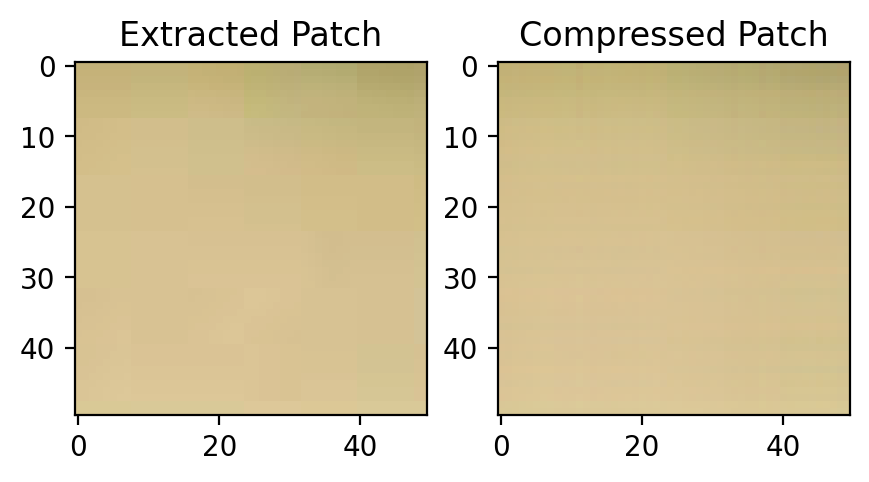

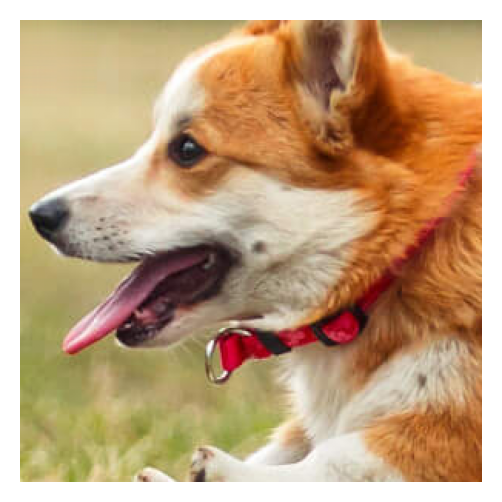

RMSE:  0.006385872838301965
PSNR:  43.89559467607434
------------------

Rank:  10


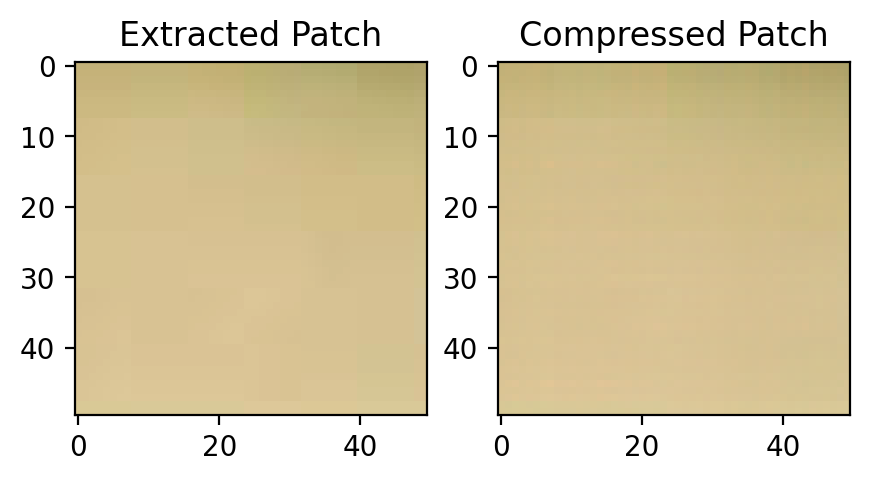

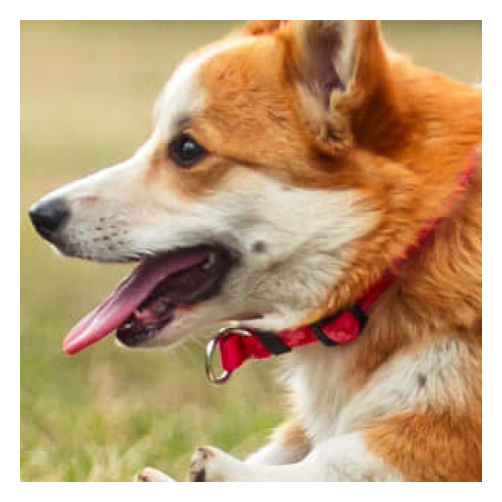

RMSE:  0.004859720969822656
PSNR:  46.26777331740914
------------------

Rank:  25


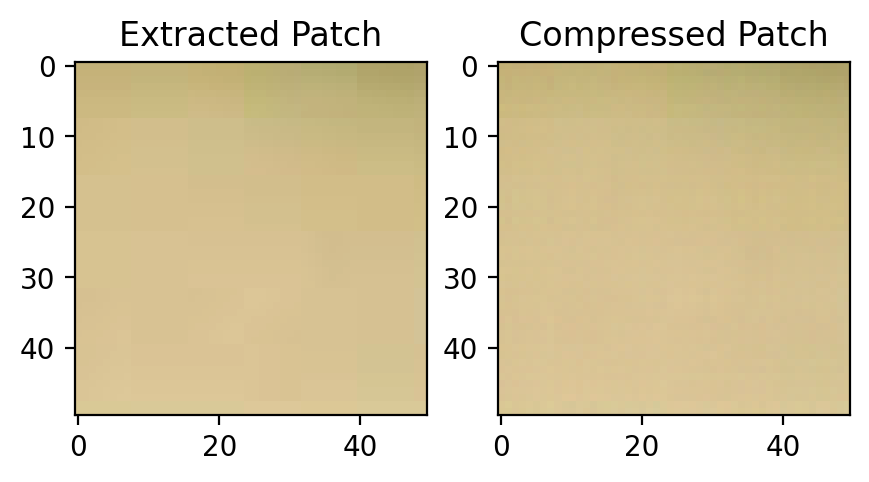

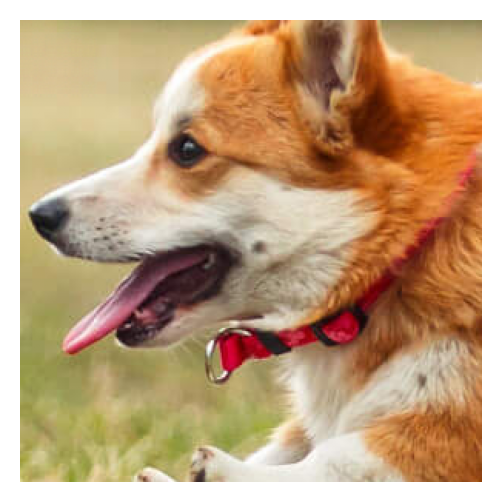

RMSE:  0.004806050028556426
PSNR:  46.364234254442174
------------------

Rank:  50


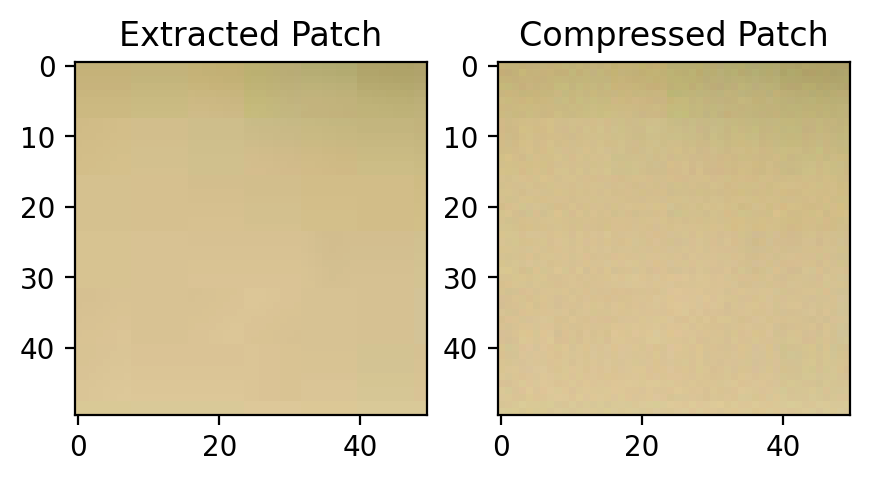

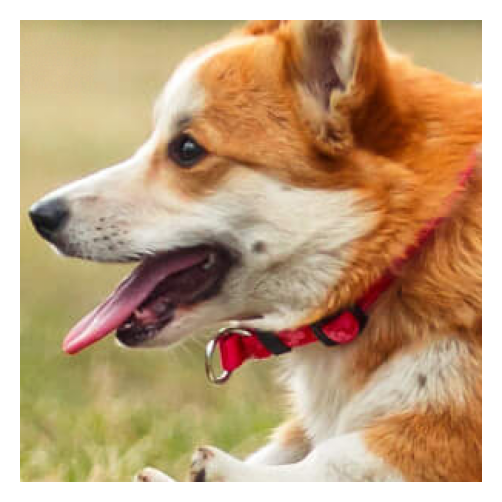

RMSE:  0.006720705164282444
PSNR:  43.451703131513725
------------------



In [33]:
# Selecting a patch
patch_size = 50
iterations = 1000
alpha = 0.01

# Patch 1

h = 0  # Starting height (row)
w = 0  # Starting width (column)
print("Patch 1")
print("h:", h, "\nw:", w)

for i in ([5,10,25,50]):
    new_crop = crop.detach().clone()
    print("Rank: ", i)
    compress_patch, RMSE, PSNR = compress_and_compare(new_crop, h, w, rank=i, iters=iterations, alpha=alpha)
    recombine(new_crop, compress_patch, h, w)
    
    print("RMSE: ", RMSE)
    print("PSNR: ", PSNR)
    print("------------------\n")

Patch 2
h: 50 
w: 50
Rank:  5


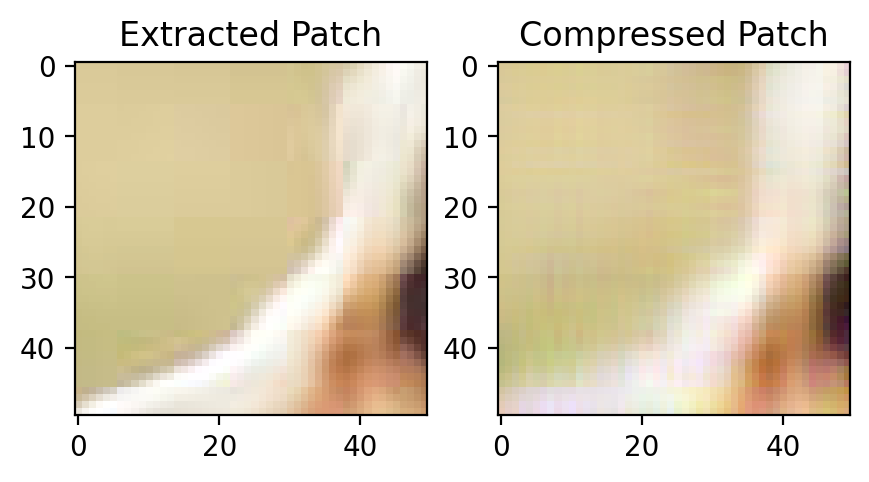

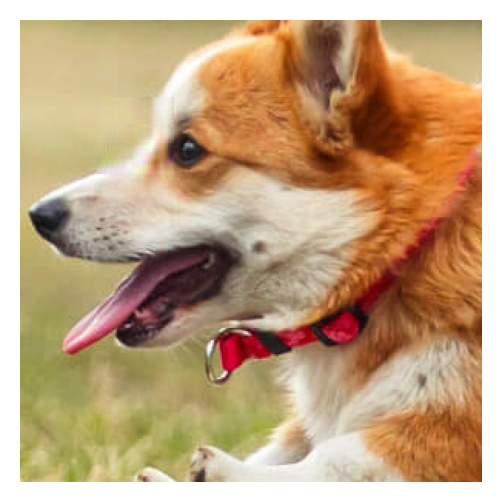

RMSE:  0.03392533514025368
PSNR:  29.389517067119016
------------------

Rank:  10


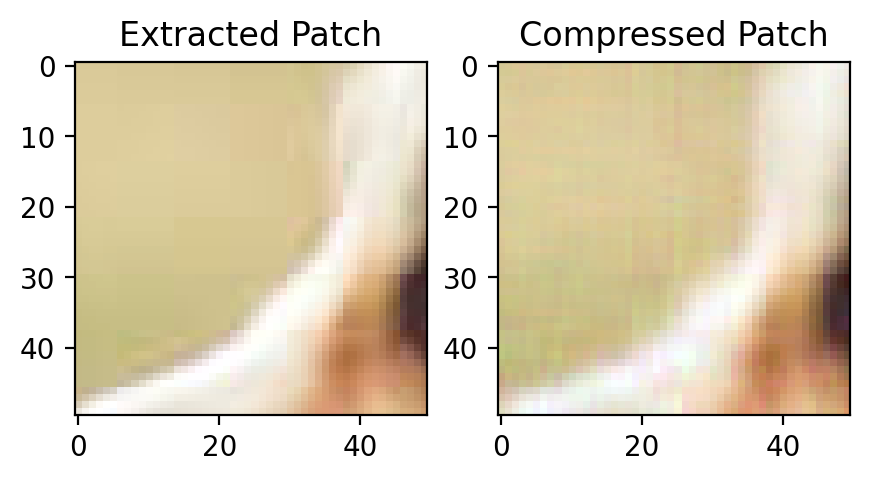

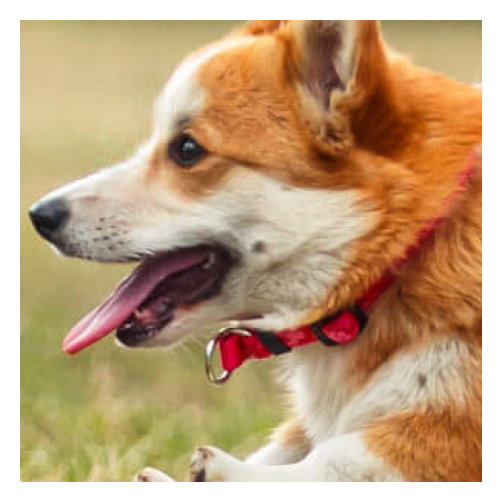

RMSE:  0.020382258682217644
PSNR:  33.81495381692561
------------------

Rank:  25


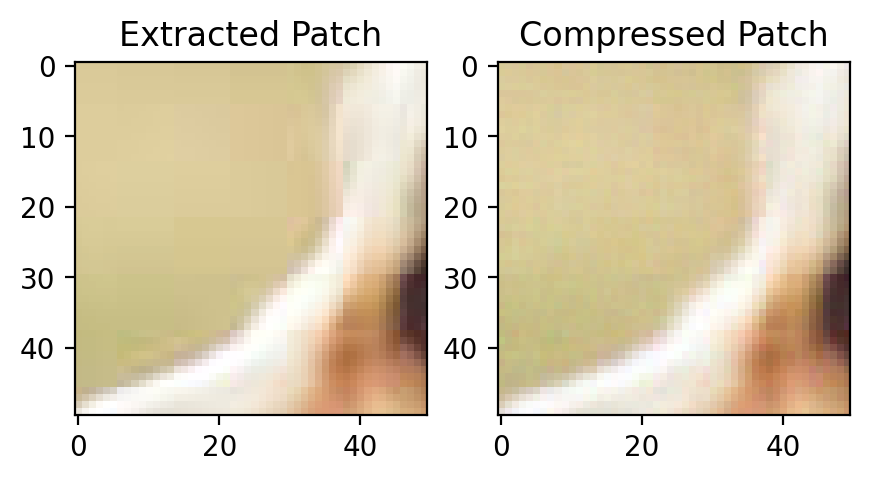

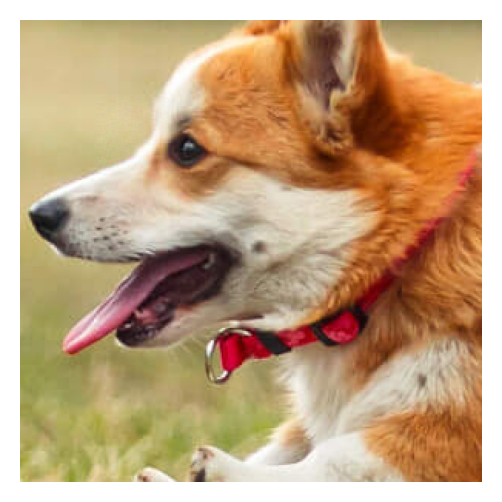

RMSE:  0.01216958654003912
PSNR:  38.29448353224304
------------------

Rank:  50


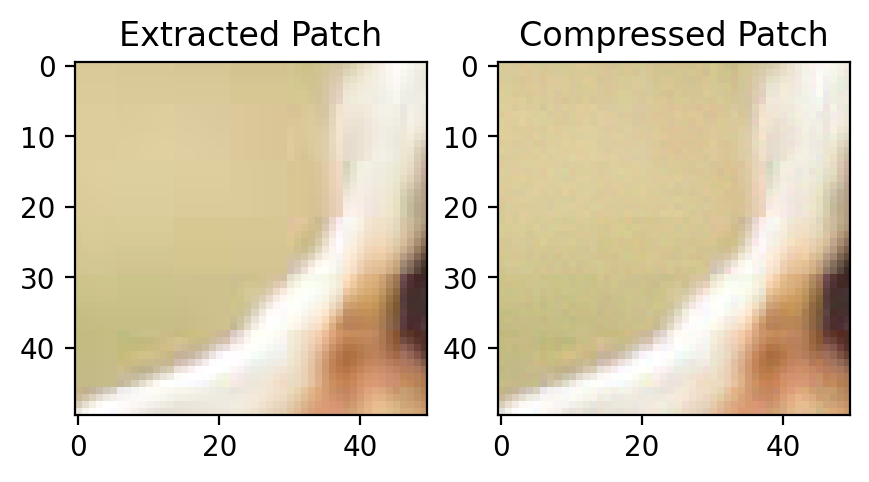

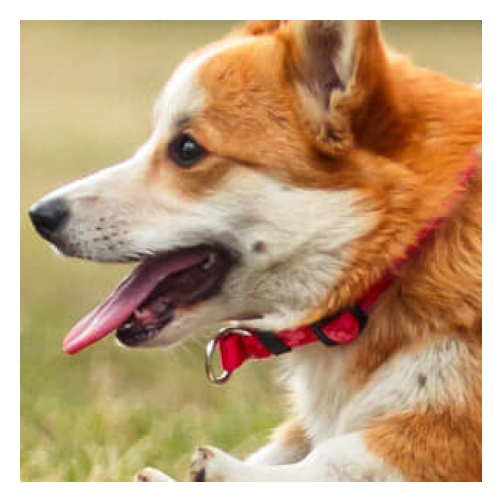

RMSE:  0.009051823023725975
PSNR:  40.86527891443146
------------------



In [34]:
# Patch 2

h = 50  # Starting height (row)
w = 50  # Starting width (column)
print("Patch 2")
print("h:", h, "\nw:", w)

for i in ([5,10,25,50]):
    new_crop = crop.detach().clone()
    print("Rank: ", i)
    compress_patch, RMSE, PSNR = compress_and_compare(new_crop, h, w, rank=i, iters=iterations, alpha=alpha)
    recombine(new_crop, compress_patch, h, w)
    
    print("RMSE: ", RMSE)
    print("PSNR: ", PSNR)
    print("------------------\n")

Patch 3
h: 175 
w: 90
Rank:  5


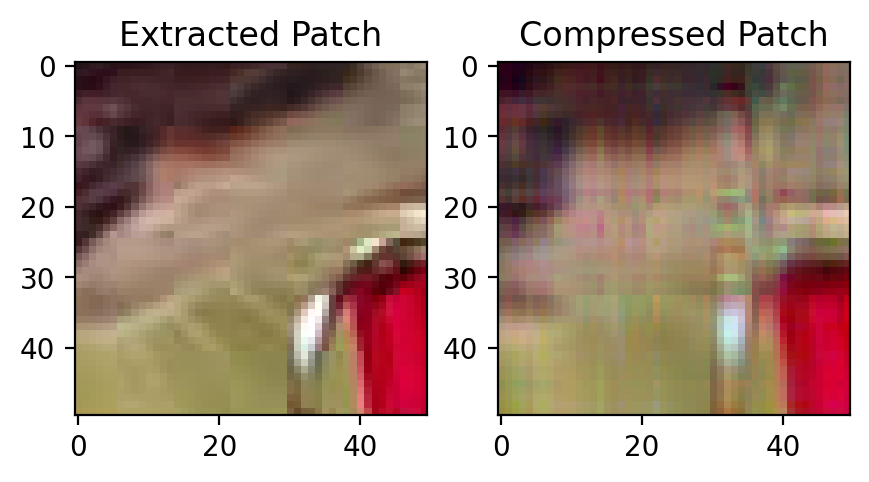

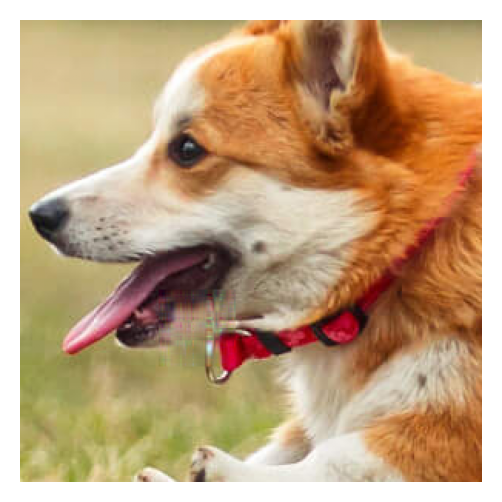

RMSE:  0.05880530997587081
PSNR:  24.611669128443452
------------------

Rank:  10


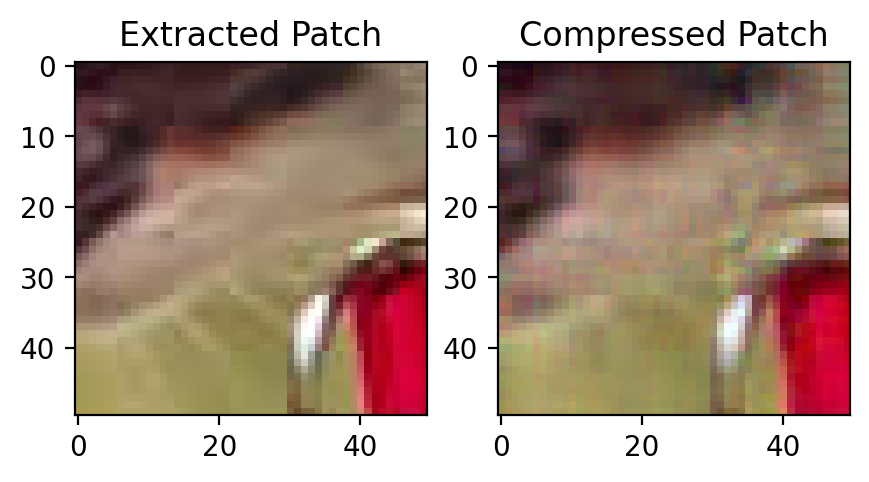

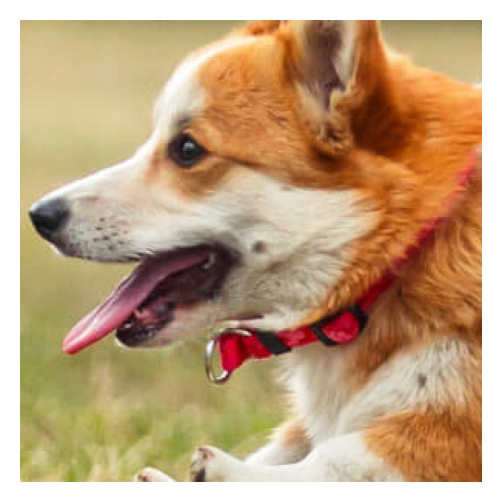

RMSE:  0.035919795423111224
PSNR:  28.893322909396964
------------------

Rank:  25


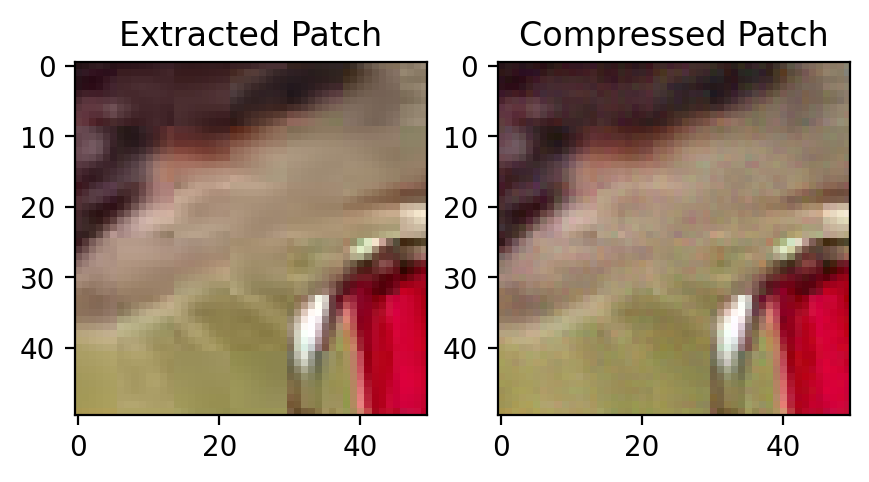

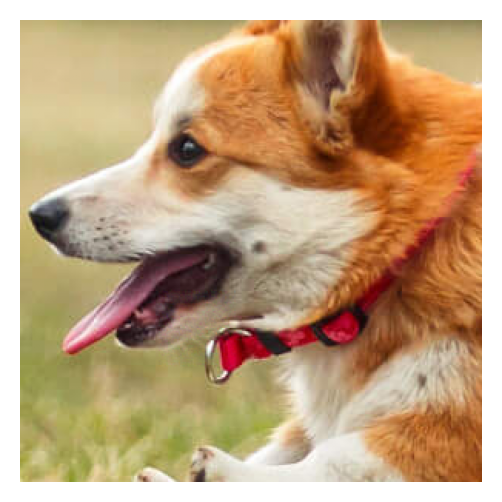

RMSE:  0.01683692981181688
PSNR:  35.47474197091687
------------------

Rank:  50


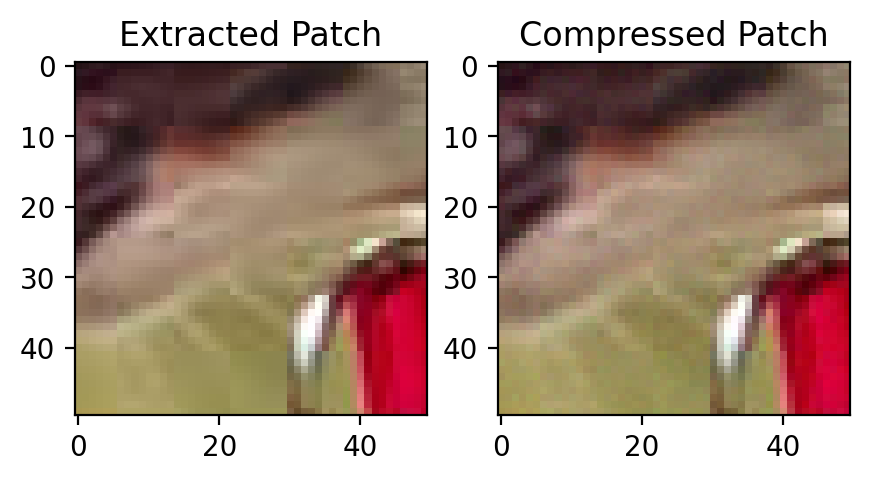

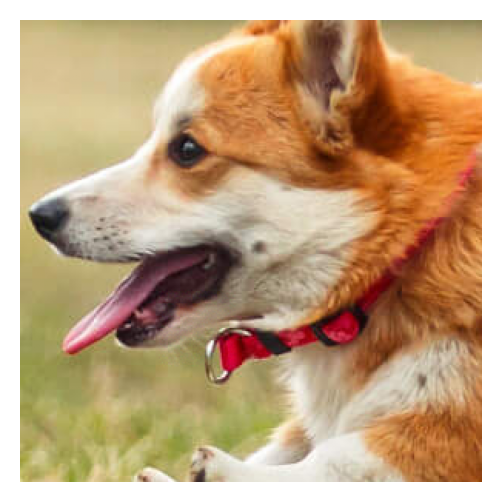

RMSE:  0.010768078182220127
PSNR:  39.35723599779662
------------------



In [35]:
# Patch 3

h = 175  # Starting height (row)
w = 90   # Starting width (column)
print("Patch 3")
print("h:", h, "\nw:", w)

for i in ([5,10,25,50]):
    new_crop = crop.detach().clone()
    print("Rank: ", i)
    compress_patch, RMSE, PSNR = compress_and_compare(new_crop, h, w, rank=i, iters=iterations, alpha=alpha)
    recombine(new_crop, compress_patch, h, w)
    
    print("RMSE: ", RMSE)
    print("PSNR: ", PSNR)
    print("------------------\n")

# Matrix Factorization for Image Compression

Matrix factorization is a powerful tool used to **approximate an image matrix** with lower-dimensional matrices. This approach does not reduce the number of pixels (i.e., the resolution), but it **compresses the information** needed to represent the image. Here’s why this form of compression is useful:

---

### 1. Lower-Rank Approximation

The main idea behind matrix factorization is to reduce the **rank** of the matrix representing the image. Instead of storing the full image matrix, you approximate it using two smaller matrices, often denoted as `W` and `H`:
- **Original Matrix**: Every pixel value is represented, and the matrix has a full rank.
- **Factorized Matrices**: The image is represented by two smaller matrices `W` and `H`, reducing the number of parameters needed.

For example, the original matrix `A` with dimensions `M x N` can be factorized into:
- `W` of size `M x r`
- `H` of size `r x N`

When `r` (the rank) is much smaller than `M` or `N`, the image is compressed because fewer parameters are stored.

---

### 2. Data Compression

In terms of storage:
- **Without Compression**: Storing the full matrix requires `M * N` values (i.e., each pixel).
- **With Matrix Factorization**: You store only `M * r + r * N` values. If `r` is much smaller than `min(M, N)`, this leads to significant storage reduction.

This results in **compression efficiency** where the image is stored using much less space without directly reducing resolution.

---

### 3. Blurring and Loss of Detail

A consequence of reducing the rank is a **loss in high-frequency details**, causing the image to appear more **blurred**. The reason for this is that the fine-grained information is discarded in favor of capturing the more prominent structures (edges, shapes, etc.).

- **Blurring** is the result of this compression, where sharp details (like edges) are lost.
- The **trade-off** between compression and image quality is what makes this technique valuable in certain use cases.

---

### 4. Use Cases

- **Efficient Storage**: Reduced image data storage leads to smaller file sizes, which is useful for storage-constrained environments.
- **Approximate Representation**: In applications like thumbnails or rough image previews, a lower-rank approximation provides a reasonable image quality with much less data.
- **Noise Reduction**: The process inherently smooths out fine details, which can also reduce noise in the image.
- **Dimensionality Reduction**: Factorization reduces the dimensionality of the image, which can be useful in other tasks like pattern recognition or machine learning.

---

### 5. Comparison to Other Compression Methods

- Techniques like **Principal Component Analysis (PCA)** or **Singular Value Decomposition (SVD)** are similar in their goal of reducing dimensionality and compressing data.
- Traditional methods like **JPEG** compression also work by transforming the image into a frequency domain and discarding less important frequency components, which is conceptually similar to matrix factorization.

---

### What if We Store Only the Multiplied Matrix?

If you **only store the multiplied matrix (i.e., the approximation `W * H`)** and not `W` and `H` separately, the compression benefit is **lost**. Here's why:
- **Without storing `W` and `H` separately**, you are no longer using the low-rank approximation but are instead storing the full matrix again.
- The main idea of matrix factorization for compression is to store two smaller matrices `W` and `H`, rather than the full product `W * H`. Storing the multiplied result (`W * H`) would take up as much space as the original image, eliminating the compression advantage.

Thus, to benefit from compression, **you must store `W` and `H` separately**, not the final multiplied matrix.

---

By using matrix factorization, you’re essentially trading off some image quality (through blurring or detail loss) for significant gains in storage efficiency.
